In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from mppi import Parsers as P
from mppi.Utilities import Constants as C
from mppi.Models import TwoLevelSystems as TLS
from mppi.Models import GaussianPulse as G
import matplotlib.pyplot as plt
import os

# TLS description of spin polarization in GaAs

In this notebook we use the TLS model to describe the time evolution of the spin polarization in GaAS.

Here we assume the a first optical pump has excited the electrons in the first two conduction bands
and we describe the dynamics in the conduction sector using the TLS. The interaction with a second
THz field is described entirely within this sector.

## TLS analysis for a single k point

The parameters common in the yambo and in the TLS analysis are

In [32]:
fwhm_THz = 20 # ps 
THz_int = 1.1767  #kW/cm2
T_delay = 1 # ps
de_ccp = 0.9445 # meV
energy = de_ccp # energy of the THz pulse
NETime = 80 # ps
ntimes = 16003 # as in the rt simulations (for the green function)

h_red = C.Planck_reduced_ev_ps*1e3 # hbar in meV*ps
omega = energy/h_red # angular frequency of the pulse

We use the TLS to reproduce the results written in

In [4]:
ref_rundir = 'SPIN_ECHO/RT_singlek_high-freq/FixSymm/'
ref_outpath = 'SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi'

In [5]:
ref_results = P.YamboParser.from_path(ref_rundir,ref_outpath)

Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.polarization
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.spin_magnetization
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.current
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.external_field
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.orbt_magnetization
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.carriers
Parse file : SPIN_ECHO/RT_singlek_high-freq/FixSymm/SAVE/ns.db1
Parse file : SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/ndb.dipoles
Parse file : SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/ndb.RT_G_PAR


In [80]:
#ref_results.get_info()

In [81]:
# We build the reference quantities to compare with the TLS results

ref_time = 1e-3*ref_results.data['external_field']['time']
ref_Ex = ref_results.data['external_field']['Ex_Re']
ref_Pz = ref_results.data['spin_magnetization']['Mc_z']

green = ref_results.RTGreen
dm = green.buildDensityMatrix(first_band=2)
Bloch = P.buildBlochVectors(dm)

There are 48 kpoint all with the same transition energy.

We use the same index structure of th RT analysis to define the dipole matrix element

In [93]:
numk = 48

In [121]:
dip_r = []
for k in range(numk):
    dip_r.append(ref_results.dipoles.get_r_dipole(k,3,2,0))
dip_r = np.array(dip_r,dtype=complex)

__IF WE CHOOSE THE TRANSPOSE MATRIX ELEMENT (K,2,3,0) THE SIGN OF U3 MATCHES BUT THE 
ROTATION FROM THE U' TO THE X,Y,Z COMPONENTS ARE WRONG....CHECK THE EQUATIONS!__

We select the first k point and set the intensity of the field to have the $\pi$ condition on this point.


In [96]:
k_ref = 0
dip_r[k_ref]

(15.276323190015635+22.948741984775978j)

We set the FWH of the THz pulse

In [97]:
theta = np.pi
pars = G.pulseParametersFromTheta(dip_r[k_ref],np.pi,fwhm=fwhm_THz,THz_pulse=True)
pars

time unit: ps
set width to 8.493218002880191 ps
Rabi coupling (ps^-1): (0.08177049377812073+0.12283911124034695j)
Rabi coupling (module) (ps^-1): 0.14756646266356058
field amplitude (V/m): 66579.79073343561
field intensity (kW/cm^2) : 1.1766689276495992


{'Omega0': (0.08177049377812073+0.12283911124034695j),
 'Omega0_abs': 0.14756646266356058,
 'field_amplitude': 66579.79073343561,
 'intensity': 1.1766689276495992}

In [98]:
amplitude = pars['field_amplitude']
Omega0_abs = pars['Omega0_abs']

We build a pulse with the aim to reproduce exactly the one created by yambo.

In [99]:
time = np.linspace(0,NETime,ntimes) # in ps

In [100]:
pulse = G.gaussianPulse(time,energy=de_ccp,amplitude=amplitude,fwhm=fwhm_THz,THz_pulse=True,t_start=T_delay,envelope_only=False)

time unit: ps - energy unit: meV
period of the oscillations 4.3786846979696366 ps
width of the pulse 8.493218002880191 ps
fwhm of the pulse 20 ps


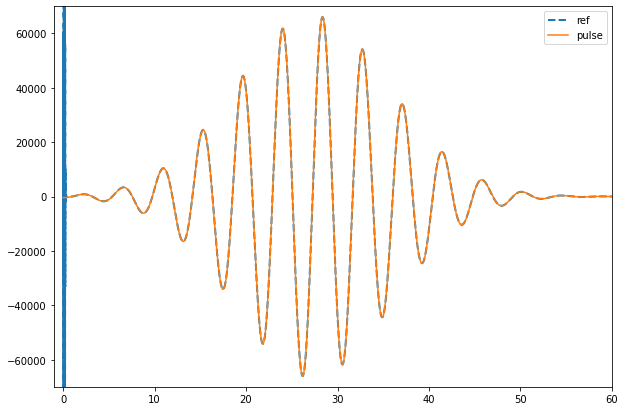

In [101]:
plt.figure(figsize=(10,7))
plt.plot(ref_time,ref_Ex,label='ref',linestyle='--',linewidth=2)
plt.plot(time,pulse,label='pulse')
plt.ylim(-70e3,70e3)
plt.xlim(-1,60)
plt.legend()

### Solution of the Bloch equations.

We use a reference calculation to extract the _initial time_ bloch vectors. We choose t=1 ps as the time value at
wich the initial condition is set. In this way the THz pulse start at t=0 in the TLS analysis

In [102]:
Bloch.shape

(3, 16003, 48)

In [103]:
ind0 = np.where(time<=1)[0][-1] 
time[ind0]

0.9998750156230471

In [104]:
Bloch0 = Bloch[:,ind0,:]
Bloch0.shape

(3, 48)

In [105]:
Bloch0[:,0]

array([0.05624854, 0.96059003, 0.02491248])

In [106]:
uprime = np.zeros([3,ntimes,numk])

In [107]:
Omega = lambda t : G.gaussianPulse(t,energy=energy,amplitude=Omega0_abs,fwhm=fwhm_THz,envelope_only=True,verbose=False)

In [108]:
delta = energy - de_ccp # in meV
delta_psm1 = delta/h_red # in ps^-1
delta_psm1

0.0

In [109]:
for k in range(numk):
    uprime0 = Bloch0[:,k]
    uprime[:,:,k] = TLS.solveBlochEq(uprime0,time,Omega,mu=dip_r[k],delta=delta_psm1)

In [110]:
uprime.shape

(3, 16003, 48)

We rotate the Bloch vector in the original frame

In [111]:
u = np.zeros([3,ntimes,numk])
for k in range(numk):
    u[:,:,k] = TLS.convertToRotatingFrame(omega,time,uprime[:,:,k],invert=True)

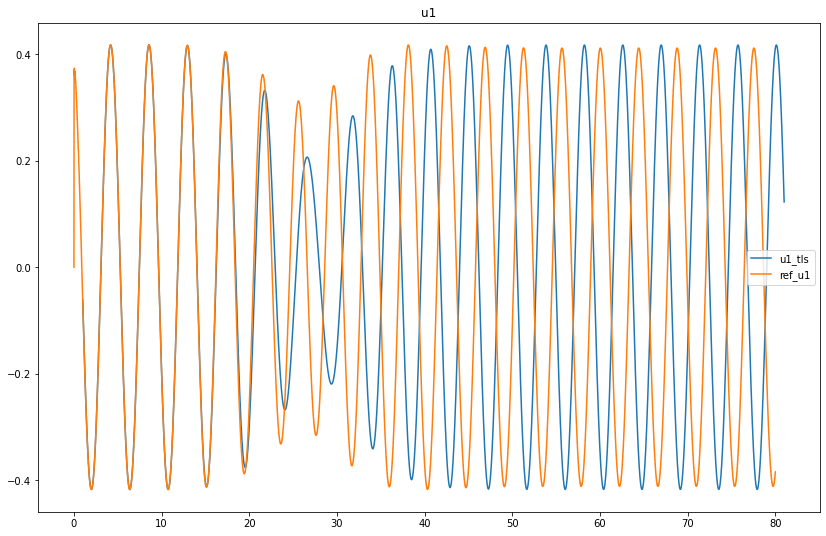

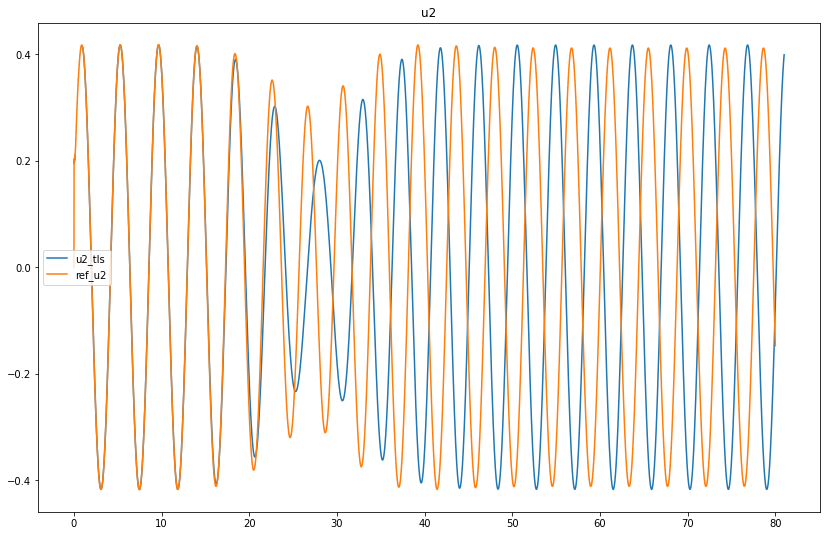

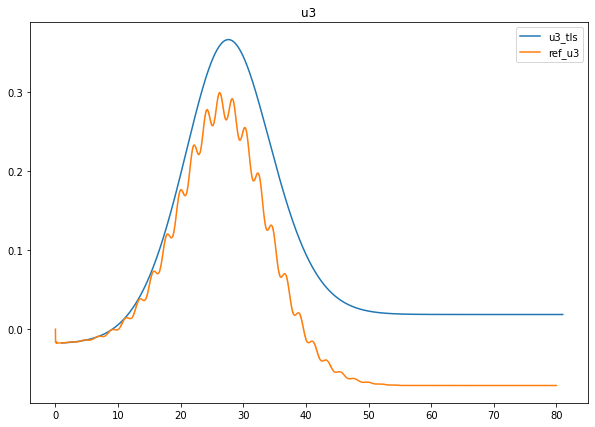

In [120]:
k = 8

plt.figure(figsize=(14,9))
plt.title('u1')
plt.plot(1+time,u[0,:,k],label='u1_tls')
plt.plot(time,Bloch[0,:,k],label='ref_u1')
plt.legend()
plt.show()

plt.figure(figsize=(14,9))
plt.title('u2')
plt.plot(1+time,u[1,:,k],label='u2_tls')
plt.plot(time,Bloch[1,:,k],label='ref_u2')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.title('u3')
plt.plot(1+time,uprime[2,:,k],label='u3_tls')
plt.plot(time,Bloch[2,:,k],label='ref_u3')
plt.legend()
plt.show()

We can compute the spin polarization obtained in the TLS description and compare it with the reference result

In [74]:
dip_spin = ref_results.dipoles.dip_spin
Szk = dip_spin[:,2:,2:,2,0] + 1j*dip_spin[:,2:,2:,2,1]
Szk.shape

(48, 2, 2)

In [89]:
Szk_EV_tls = np.zeros([ntimes,numk])
for t in range(ntimes):
    for k in range(numk):
        Szk_EV_tls[t,k] = u[0,t,k]*(Szk[k,0,1].real) + u[1,t,k]*(Szk[k,0,1].imag)-2*u[2,t,k]*(Szk[k,0,0].real)
Pz_tls = np.mean(Szk_EV_tls,axis=1) # average over k

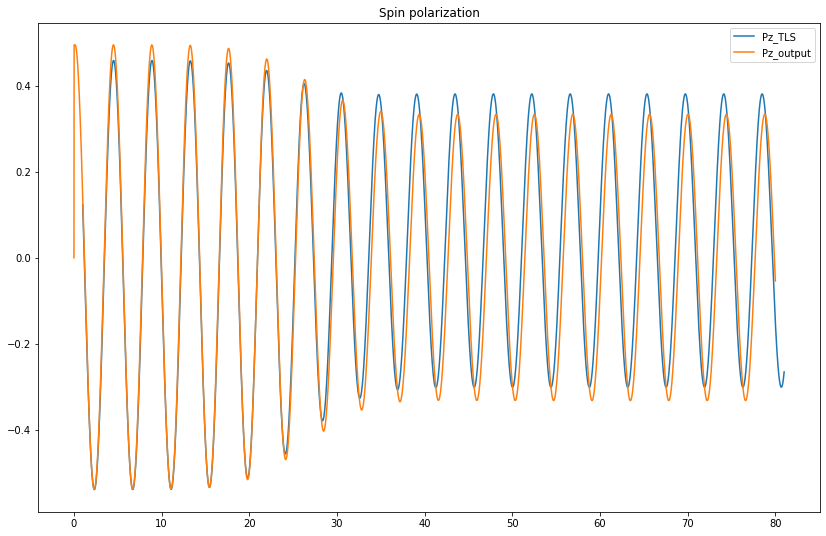

In [92]:
plt.figure(figsize=(14,9))
plt.plot(1+time,Pz_tls,label='Pz_TLS')
plt.plot(ref_time,ref_Pz,label='Pz_output')
plt.title('Spin polarization')
plt.legend()

In [ ]:
##################################################################################################à




Once that we have the Bloch vector we can compute the expectation value of the spin polarization

In [102]:
dip_spin = ref.dipoles.dip_spin
Sz = dip_spin[:,2:,2:,2,0] + 1j*dip_spin[:,2:,2:,2,1]
Sz.shape

(48, 2, 2)

In [103]:
pz_k = np.zeros([N,nk])
for k in range(nk):
    A = Sz[k,0,0].real
    B = Sz[k,0,1].real
    C = Sz[k,0,1].imag
    pz_k[:,k] = (A*bloch_of[2,:,k]+B*bloch_of[0,:,k]+C*bloch_of[1,:,k]) 

In [104]:
pz_avg = np.zeros([N])
for t in range(N):
    pz_avg[t] = np.average(pz_k[t,:].real)

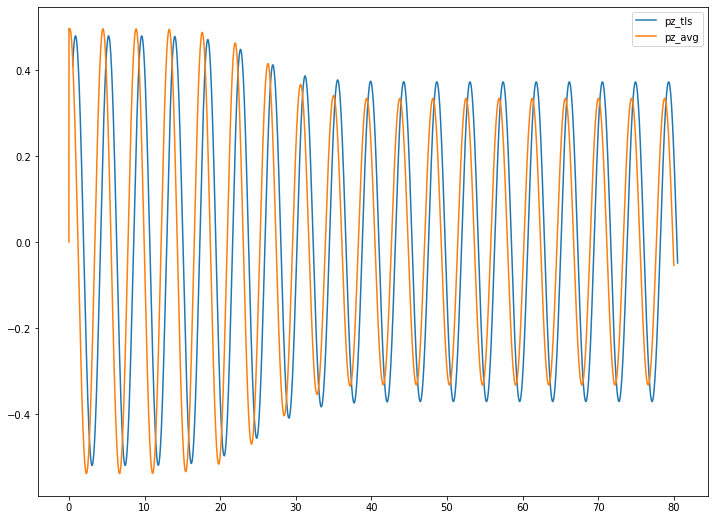

In [105]:
plt.figure(figsize=(12,9))
plt.plot(t0+pulse_time,pz_avg,label='pz_tls')
plt.plot(ref_time,ref_pz,label='pz_avg')
plt.legend()